In [1]:
%matplotlib inline
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def printmd(data):
    display(Markdown(data))

In [3]:
# loop time
LOOP_TIME = 10000 / 1e6
LOOP_TIME

0.01

In [4]:
columns = ['gx', 'gy', 'gz', 'ax', 'ay', 'az', 'angx', 'angy', 'angz', 'pidx', 'pidy', 'pidz']
data = []
with open('./data_1.txt', 'r') as f:
    data = [l.strip()[:-1] for l in f.readlines() if len(l.strip()) > 0]
data = [[float(_d) for _d in d.split(',')] for d in data]
data = np.array(data)
df_raw_data = pd.DataFrame(data=data, columns=columns)
df_raw_data

,gx,gy,gz,ax,ay,az,angx,angy,angz,pidx,pidy,pidz
0,-0.35,-0.03,0.03,-0.06,0.28,9.39,1.26,-0.37,-5.96,-6.38,1.81,0.0
1,-0.26,-0.11,0.00,-0.07,0.28,9.61,1.26,-0.37,-5.96,-6.29,1.74,0.0
2,-0.26,0.09,-0.03,-0.09,0.29,9.36,1.26,-0.37,-5.96,-6.29,1.93,0.0
3,-0.31,-0.05,0.02,-0.05,0.29,9.59,1.26,-0.37,-5.95,-6.33,1.80,0.0
4,-0.26,0.09,-0.06,-0.06,0.27,9.50,1.26,-0.37,-5.95,-6.29,1.93,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1678,-0.34,0.00,-0.06,-0.13,0.32,9.50,1.14,0.52,2.43,-5.61,-3.23,0.0
1679,-0.38,0.05,-0.02,-0.13,0.32,9.51,1.14,0.51,2.43,-5.65,-3.16,0.0
1680,-0.27,0.03,-0.03,-0.11,0.31,9.52,1.14,0.51,2.43,-5.55,-3.15,0.0
1681,-0.26,0.06,0.09,-0.07,0.31,9.50,1.14,0.50,2.43,-5.54,-3.09,0.0


In [5]:
data = [[0,0,0]]
# for 
for d in df_raw_data[['gx', 'gy', 'gz']].values:
    data.append([
        data[-1][0] + d[0] * LOOP_TIME,
        data[-1][1] + d[1] * LOOP_TIME,
        data[-1][2] + d[2] * LOOP_TIME
    ])
data = np.array(data[1:])

df_gyro_angle = pd.DataFrame(data=data, columns=['x', 'y', 'z'])

In [6]:
# state = np.array([0,0,0]).reshape(-1,1)
# P = np.eye(3)
# Q = np.diag([0.01, 0.01, 0.00])
# R = np.diag([0.1, 0.1, 0.1])
# prev_accel_angle = np.array([0,0,0]).reshape(-1,1)
# alpha = 0.96


class ExtendedKalmanFilter:

    def __init__(self, P, Q, R, alpha):
        self.state = np.array([0,0,0]).reshape(-1,1)
        self.P = P
        self.Q = Q
        self.R = R
        self.prev_accel_angle = np.array([0,0,0]).reshape(-1,1)
        self.alpha = alpha
    
    def ekf_update(self, gyro, accl_angle):
        global state
        global P
        global Q
        global R
        global prev_accel_angle
        global alpha
        
        self.state = self.state + gyro * LOOP_TIME
        self.P = self.P + self.Q
    
    
    
        # accl_angle =  self.prev_accel_angle*self.alpha + (1 - self.alpha)*accl_angle
        accl_angle = (1 - self.alpha) * self.prev_accel_angle + self.alpha*accl_angle
        self.prev_accel_angle = accl_angle
        residual = accl_angle - self.state
        
        K = self.P.dot(np.linalg.inv(self.P + self.R))
        self.state = self.state + K.dot(residual)
        self.P = (np.eye(3) - K).dot(self.P)
        return self.state
    
# P = np.eye(3)
# Q = np.diag([0.01, 0.01, 0.00])
# R = np.diag([1.1, 1.1, 1.1])
# alpha = 0.04

P = np.eye(3)
# Q = np.diag([0.02318644, 0.02318644, 0.0])
Q = np.diag([0.005, 0.005, 0.0])
R = np.diag([100, 100, 100])
alpha = 0.04



ekf = ExtendedKalmanFilter(P, Q, R, alpha)

ekf_states = []

for i in range(df_raw_data.shape[0]):
    row = df_raw_data.iloc[i]
    gyro_data = row[['gx', 'gy', 'gz']].values.reshape(-1,1)
    accl_data = row[['ax', 'ay', 'az']].values
    accl_angle = np.rad2deg(np.array([
        np.arctan(accl_data[1] / np.sqrt(accl_data[0]**2 + accl_data[2]**2)),
        np.arctan(accl_data[0] / np.sqrt(accl_data[1]**2 + accl_data[2]**2)),
        0
    ]))
    accl_angle = accl_angle.reshape(-1,1)
    updated_state = ekf.ekf_update(gyro_data, accl_angle)
    ekf_states.append(updated_state.reshape(3))

ekf_states = pd.DataFrame(data=np.array(ekf_states), columns=['x', 'y', 'z'])


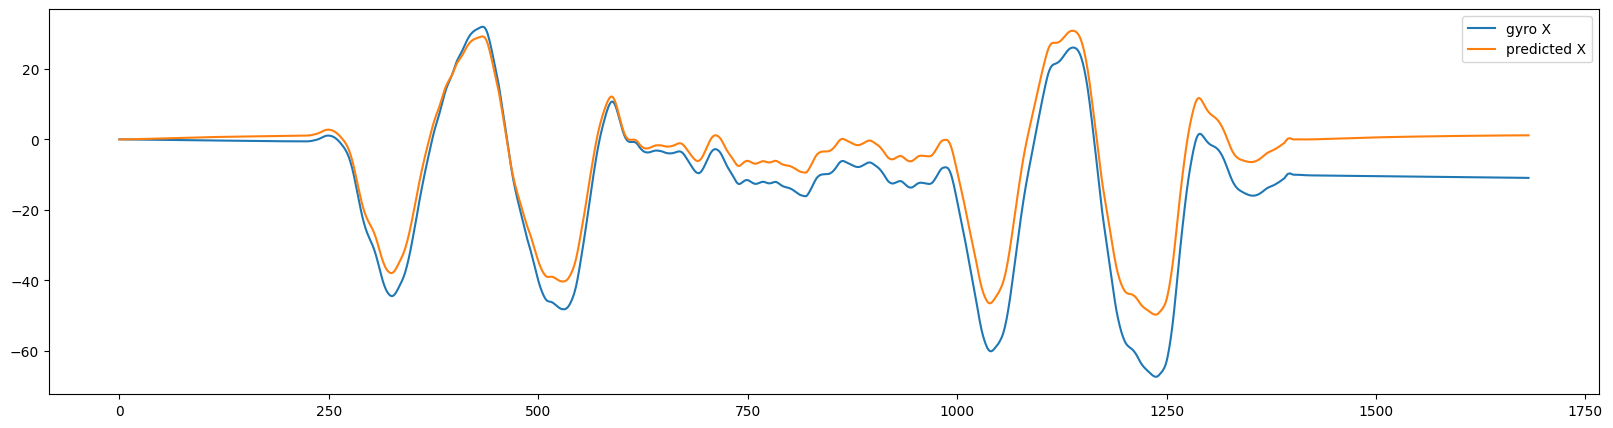

In [9]:
plot_data = [
    [df_gyro_angle['x'], 'gyro X'],
    [ekf_states['x'], 'predicted X'],
    # [df_raw_data['angx'], 'received angx'],
    # [df_raw_data['pidx'], 'pidx']
]

plt.figure(figsize=(20, 5))
for d, _ in plot_data:
    plt.plot(d)
plt.legend([p[1] for p in plot_data])
plt.show()

In [2]:
df_gyro_angle['x'].values[-100], ekf_states['x'].values[-100]

NameError: name 'df_gyro_angle' is not defined

# Using algorithm to optimize

In [11]:
def mean_square_error(arr1, arr2):
    return np.mean((arr1 - arr2)**2)

def roughness(arr):
    return np.mean(arr**2)

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [12]:
dataset = []
# P = np.eye(3)
# Q = np.diag([0.01, 0.01, 0.00])
# R = np.diag([1.1, 1.1, 1.1])
alpha = 0.04


gap = 0.001
starting_at = 0.001
ending_at = 0.12
for q in np.linspace(starting_at, ending_at, int((ending_at - starting_at) / gap)+1):
    gap = 1
    starting_at = 80
    ending_at = 80
    for r in np.linspace(starting_at, ending_at, int((ending_at - starting_at) / gap)+1):
        dataset.append((
            np.eye(3),
            np.diag([q, q, 0]),
            np.diag([r, r, r]),
            alpha
        ))
len(dataset)

119

In [13]:
def calculate_ekf_for_each_step(df_raw_data, P, Q, R, alpha):
    ekf = ExtendedKalmanFilter(P,Q, R, alpha)
    
    ekf_states = []
    for i in range(df_raw_data.shape[0]):
        row = df_raw_data.iloc[i]
        gyro_data = row[['gx', 'gy', 'gz']].values.reshape(-1,1)
        accl_data = row[['ax', 'ay', 'az']].values
        accl_angle = np.rad2deg(np.array([
            np.arctan(accl_data[1] / np.sqrt(accl_data[0]**2 + accl_data[2]**2)),
            np.arctan(accl_data[0] / np.sqrt(accl_data[1]**2 + accl_data[2]**2)),
            0
        ]))
        accl_angle = accl_angle.reshape(-1,1)
        updated_state = ekf.ekf_update(gyro_data, accl_angle)
        ekf_states.append(updated_state.reshape(3))
    
    ekf_states = pd.DataFrame(data=np.array(ekf_states), columns=['x', 'y', 'z'])
    return ekf_states



error_data = []

for data in tqdm(dataset):
    P, Q, R, alpha = data
    df_predicted_data = calculate_ekf_for_each_step(df_raw_data, P, Q, R, alpha)
    mean_sq_err = mean_square_error(df_gyro_angle['x'].values, df_predicted_data['x'].values)
    first_order = np.gradient(df_predicted_data['x'].values, np.arange(df_predicted_data['x'].shape[0]))
    second_order = np.gradient(first_order, np.arange(first_order.shape[0]))
    error_data.append([
        mean_sq_err,
        roughness(first_order),
        roughness(second_order)
    ])
    
error_data = np.array(error_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [01:33<00:00,  1.27it/s]


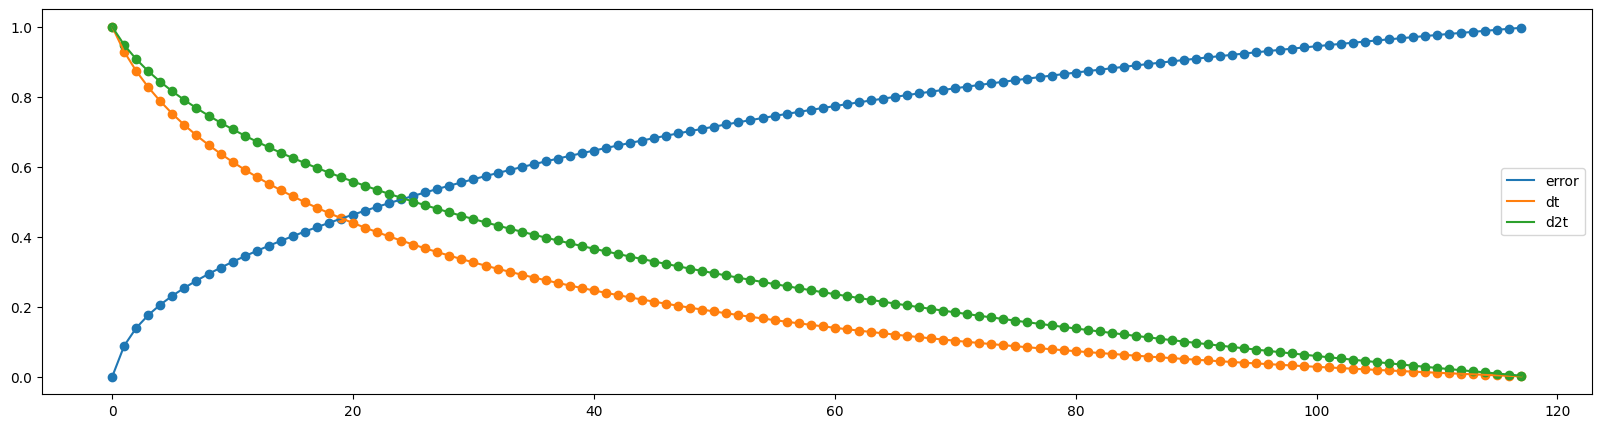

In [14]:
start = 0
end = -1

# start = 15
# end = 25

plot_data = [
    [normalize(error_data[:, 0])[start:end], 'error'],
    [normalize(error_data[:, 1])[start:end], 'dt'],
    [normalize(error_data[:, 2])[start:end], 'd2t'],
    # [df_raw_data['angx'], 'received angx'],
    # [df_raw_data['pidx'], 'pidx']
]

plt.figure(figsize=(20, 5))
for d, _ in plot_data:
    plt.plot(d)
plt.legend([p[1] for p in plot_data])
for d, _ in plot_data:
    plt.scatter(list(range(len(d))), d)
plt.show()

In [15]:
error_data[start:end][19]

array([9.00271683e+01, 2.64764351e-01, 1.53371740e-03])

In [16]:
dataset[start:end][19]

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[0.02016102, 0.        , 0.        ],
        [0.        , 0.02016102, 0.        ],
        [0.        , 0.        , 0.        ]]),
 array([[80.,  0.,  0.],
        [ 0., 80.,  0.],
        [ 0.,  0., 80.]]),
 0.04)